In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [3]:
common_config.figure_journal_basic()

In [4]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
from gprofiler import gprofiler
import matplotlib.cm
import matplotlib.colors

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
adata = pt.dt.mcfarland_2020()
adata = adata[adata.obs["perturbation_type"] == "drug"]
adata

View of AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We want to query the GDSC scores for the cell line-perturbation combinations in our dataset. We tested annotating either via SangerID, COSMICID, or cell line name. We found that most cell lines are identified when using the SangerID.

In [6]:
cl_metadata = pt.md.CellLine()

cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["SangerModelID"],
)

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_1",
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset="gdsc_2",
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
💡 There are 140 identifiers in `adata.obs`.However, 25 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 154710 × 32738
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [7]:
# Check for how many cell lines we have GDSC data (each cell line is expected to have a different GDSC score, except for the control)
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     115
Navitoclax      68
Dabrafenib      67
Afatinib        65
Gemcitabine     65
Taselisib       64
JQ1             63
Bortezomib      16
AZD5591          1
BRD3379          1
Everolimus       1
Idasanutlin      1
Prexasertib      1
control          1
Name: count, dtype: int64

In [8]:
adata.obs[["perturbation", "cell_line"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     171
control        171
BRD3379         98
Dabrafenib      98
Navitoclax      98
Afatinib        95
Gemcitabine     95
Prexasertib     95
Taselisib       95
AZD5591         94
Everolimus      94
JQ1             94
Bortezomib      24
Idasanutlin     24
Name: count, dtype: int64

In [9]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

,ln_ic50_GDSC1,ln_ic50_GDSC2
ln_ic50_GDSC1,1.000000,0.839123
ln_ic50_GDSC2,0.839123,1.000000


# Methods

In [10]:
def comp_edger(adata_temp, perturbation):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    logfc_df = pd.DataFrame(columns=adata_temp.var_names)
    
    for cell_line in tqdm(adata_temp.obs["SangerModelID"].unique()):
        
        subset = adata_temp[adata_temp.obs["SangerModelID"] == cell_line]
        if subset.n_obs < 20: #Threshold from the McFarland paper
            continue
        if perturbation not in subset.obs["perturbation"].unique():
            continue
        
        edgr = pt.tl.EdgeR(subset, design="~perturbation")
        edgr.fit()
        
        res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", perturbation))
        res_df = res_df[["variable", "log_fc"]]
        res_df = res_df.set_index("variable")
        res_df = res_df.reindex(adata.var_names)
        
        logfc_df.loc[cell_line] = res_df["log_fc"]
    
    logfc_df.to_csv(f"output/logfc_df_{perturbation}.csv")
    
    return logfc_df

In [11]:
def comp_linear_regression(adata_temp, perturbation, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]

    lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    for gene in tqdm(logfc_df.columns):
        y = logfc_df.loc[cell_lines][gene].values
        y = y[~na_mask]
        X = sm.add_constant(X)
        model = sm.OLS(y, X)
        results = model.fit()
        
        lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]
    
    #Filter out with both zero slope AND intercept
    lr_params = lr_params[(lr_params["slope"] != 0) | (lr_params["intercept"] != 0)]
    
    #Multiple testing correction
    lr_params["slope_pval_corrected"] = sm.stats.multipletests(lr_params["slope_pval"], method="fdr_bh")[1]
    lr_params["intercept_pval_corrected"] = sm.stats.multipletests(lr_params["intercept_pval"], method="fdr_bh")[1]
        
    lr_params["-log10(slope_pval_corrected)"] = -np.log10(lr_params["slope_pval_corrected"])
    lr_params["-log10(intercept_pval_corrected)"] = -np.log10(lr_params["intercept_pval_corrected"])
    
    return lr_params

In [12]:
def plot_example_linear_regression(adata_temp, perturbation, gene, gdsc_dataset, logfc_df):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    print(adata_temp.obs["perturbation"].value_counts())
    
    assert gdsc_dataset in [1, 2]
    
    cell_lines = logfc_df.index
    sens_cell_lines = adata_temp.obs[[f"ln_ic50_GDSC{gdsc_dataset}", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
    cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]
    
    X = sens_cell_lines.loc[cell_lines][f"ln_ic50_GDSC{gdsc_dataset}"].values
    na_mask = np.isnan(X)
    X = X[~na_mask]
    
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    sns.scatterplot(
        x=X[:, 1],
        y=y,
        ax=ax,
    )

    sns.regplot(
        x=X[:, 1],
        y=y,
        scatter=False,
        color="red",
        ax=ax,
    )
    
    ax.set_xlabel(f"ln_ic50_GDSC{gdsc_dataset}")
    ax.set_ylabel(f"logfc_{gene}")
    
    plt.savefig(f"figures/linear_regression_{perturbation}_{gene}.pdf", bbox_inches="tight")
    plt.close()

In [13]:
def volcano_plot(lr_params, perturbation, coeff, pval_threshold=0.05, value_threshold=0.5):
    assert coeff in ["slope", "intercept"]
    
    # Assign color based on p-value and effect size
    lr_params["color"] = "lightblue"
    lr_params.loc[(lr_params[coeff] > value_threshold) 
                  & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold), "color"] = "red"
    lr_params.loc[(lr_params[coeff] < -value_threshold) 
                  & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold), "color"] = "blue"
    
    lr_params["size"] = 1
    lr_params.loc[lr_params["color"].isin(["red", "blue"]), "size"] = 1.1
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.scatterplot(
        data=lr_params,
        x=coeff,
        y="-log10({}_pval_corrected)".format(coeff),
        hue="color",
        palette={"lightblue": "lightblue", "red": common_config.pt_red, "blue": common_config.pt_blue},
        size="size",
        ax=ax,
    )
    
    sig_genes = lr_params[lr_params["color"].isin(["red", "blue"])].sort_values("-log10({}_pval_corrected)".format(coeff), ascending=False)[:8]
    for i, gene in enumerate(sig_genes.index):
        ax.text(sig_genes.loc[gene, coeff], sig_genes.loc[gene, "-log10({}_pval_corrected)".format(coeff)], gene, fontsize=8)
        
    ax.get_legend().remove()
    
    plt.savefig(f"figures/volcano_plot_{perturbation}_{coeff}.pdf", bbox_inches="tight")
    plt.show()

In [14]:
def gsea(lr_params, perturbation, coeff, pval_threshold=0.05, domain="all"):
    assert coeff in ["slope", "intercept"]
    
    genes_up = lr_params[(lr_params[coeff] > 0) 
                         & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold)].index
    genes_down = lr_params[(lr_params[coeff] < 0) 
                           & (lr_params[f"{coeff}_pval_corrected"] < pval_threshold)].index
    print(f"Number of genes UP: {len(genes_up)}, DOWN: {len(genes_down)}")

    results_up = gprofiler(query=genes_up, organism='hsapiens')
    results_down = gprofiler(query=genes_down, organism='hsapiens')
    
    results_up.to_csv(f"output/gsea_{perturbation}_{coeff}_up.csv")
    results_down.to_csv(f"output/gsea_{perturbation}_{coeff}_down.csv")
    
    print(results_up["domain"].unique())
    print(f"Number of pathways UP: {len(results_up)}, DOWN: {len(results_down)}")
    
    if domain != "all":
        results_up = results_up[results_up["domain"] == domain]
        results_down = results_down[results_down["domain"] == domain]
    
    enrichment_up = results_up.sort_values(by="p.value", ascending=True)[:3]
    enrichment_down = results_down.sort_values(by="p.value", ascending=True)[:3]
    
    def make_cbar(values, cmap, ax):
        norm = plt.Normalize(vmin=values.min(), vmax=values.max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        ax.get_legend().remove()
        ax.figure.colorbar(sm, ax=ax, label="p-value")
    
    try:
        matplotlib.cm.get_cmap("rb")
    except ValueError:
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red", "blue"])
        matplotlib.cm.register_cmap("rb", cmap)
    
    # Plot the GSEA results in two subplots
    plt.subplots(2, 1, figsize=(4, 5))
    
    plt.subplot(2, 1, 1)
    enrichment_up = enrichment_up.sort_values(by="p.value")
    sns.barplot(
        data=enrichment_up,
        x="overlap.size",
        y="term.name",
        hue="p.value",
        palette="rb",
    )
    make_cbar(enrichment_up["p.value"], "rb", plt.gca())
    plt.title(f"Upregulated")
    plt.xlabel("")
    
    
    plt.subplot(2, 1, 2)
    sns.barplot(
        data=enrichment_down,
        x="overlap.size",
        y="term.name",
        hue="p.value",
        palette="rb",
    )
    make_cbar(enrichment_down["p.value"], "rb", plt.gca())
    plt.title(f"Downregulated")
    plt.xlabel("Gene count")
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    
    plt.savefig(f"figures/gsea_{perturbation}_{coeff}.pdf", bbox_inches="tight")

# Dabrafenib

In [15]:
#logfc_df_dabrafenib = comp_edger(adata, "Dabrafenib")
logfc_df_dabrafenib = pd.read_csv("output/logfc_df_dabrafenib.csv", index_col=0)
logfc_df_dabrafenib = logfc_df_dabrafenib.loc[:, (logfc_df_dabrafenib != 0).any(axis=0)]
logfc_df_dabrafenib

,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.9,AP006222.2,RP4-669L17.10,RP4-669L17.2,RP5-857K21.15,RP5-857K21.1,RP5-857K21.2,...,ZNF84-1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,AL590523.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5
SIDM00956,0.110806,0.0,0.040469,0.0,0.503941,-0.074615,0.000000,0.000000,0.0,0.0,...,0.0,0.391449,0.114092,0.108143,0.0,0.0,0.000000,0.096192,0.0,0.0
SIDM00726,0.065218,0.0,0.140023,0.0,0.305291,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.266109,-0.308716,0.409073,0.0,0.0,0.074854,0.085888,0.0,0.0
SIDM00235,0.102375,0.0,-0.047975,0.0,0.417356,0.085246,0.000000,0.000000,0.0,0.0,...,0.0,0.104158,-0.038760,0.047454,0.0,0.0,0.124005,0.553646,0.0,0.0
SIDM00683,0.006955,0.0,0.163923,0.0,0.570855,0.142942,0.000000,-0.015124,0.0,0.0,...,0.0,0.499577,0.000000,0.114323,0.0,0.0,0.029900,0.333295,0.0,0.0
SIDM00919,-0.082907,0.0,0.117955,0.0,0.185251,0.021173,0.000000,0.000000,0.0,0.0,...,0.0,0.415047,0.141257,0.465122,0.0,0.0,-0.057485,0.207427,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00645,0.000000,0.0,0.000000,0.0,-0.072492,0.196135,0.000000,0.000000,0.0,0.0,...,0.0,-0.025778,0.066574,0.059770,0.0,0.0,-0.038205,-0.132830,0.0,0.0
SIDM01002,0.039906,0.0,-0.101481,0.0,0.326621,-0.286880,0.154587,0.000000,0.0,0.0,...,0.0,0.527736,0.000000,0.216123,0.0,0.0,0.000000,-0.419123,0.0,0.0
SIDM00840,0.054145,0.0,0.174480,0.0,-0.062687,0.096355,0.000000,0.000000,0.0,0.0,...,0.0,-0.162193,-0.242916,-0.004852,0.0,0.0,-0.214519,0.285947,0.0,0.0
SIDM00165,0.000000,0.0,0.205827,0.0,0.246678,-0.073403,0.000000,0.000000,0.0,0.0,...,0.0,-0.039529,0.000000,-0.007132,0.0,0.0,-0.177176,-0.131627,0.0,0.0


In [16]:
lr_params_dabrafenib = comp_linear_regression(adata, "Dabrafenib", 2, logfc_df_dabrafenib)
lr_params_dabrafenib.to_csv("output/linear_regression_results_dabrafenib.csv")

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


100%|██████████| 28243/28243 [01:02<00:00, 452.64it/s]


In [17]:
lr_params_dabrafenib

,gene,slope,intercept,slope_pval,intercept_pval,slope_pval_corrected,intercept_pval_corrected,-log10(slope_pval_corrected),-log10(intercept_pval_corrected)
RP11-34P13.7,RP11-34P13.7,0.000022,0.005699,0.997272,0.860131,0.999785,0.963280,0.000093,0.016248
RP11-34P13.8,RP11-34P13.8,-0.000383,0.001095,0.609283,0.770165,0.898552,0.936466,0.046457,0.028508
AL627309.1,AL627309.1,0.002659,0.007886,0.770188,0.862469,0.949235,0.963554,0.022626,0.016124
RP11-34P13.9,RP11-34P13.9,0.000265,-0.001583,0.167514,0.100773,0.537979,0.330061,0.269235,0.481406
AP006222.2,AP006222.2,0.027331,-0.045835,0.100432,0.578248,0.404439,0.856802,0.393147,0.067120
...,...,...,...,...,...,...,...,...,...
AL590523.1,AL590523.1,0.001265,-0.006776,0.007989,0.004663,0.074455,0.032305,1.128108,1.490731
PNRC2-1,PNRC2-1,-0.005186,0.028644,0.594556,0.556809,0.893222,0.845932,0.049041,0.072664
SRSF10-1,SRSF10-1,0.034598,-0.176194,0.026582,0.024067,0.169576,0.117309,0.770637,0.930670
AC145205.1,AC145205.1,-0.000107,0.000011,0.696130,0.993441,0.930617,0.999041,0.031229,0.000416


In [18]:
#lr_params_dabrafenib = pd.read_csv("output/linear_regression_results_dabrafenib.csv", index_col=0)
#lr_params_dabrafenib

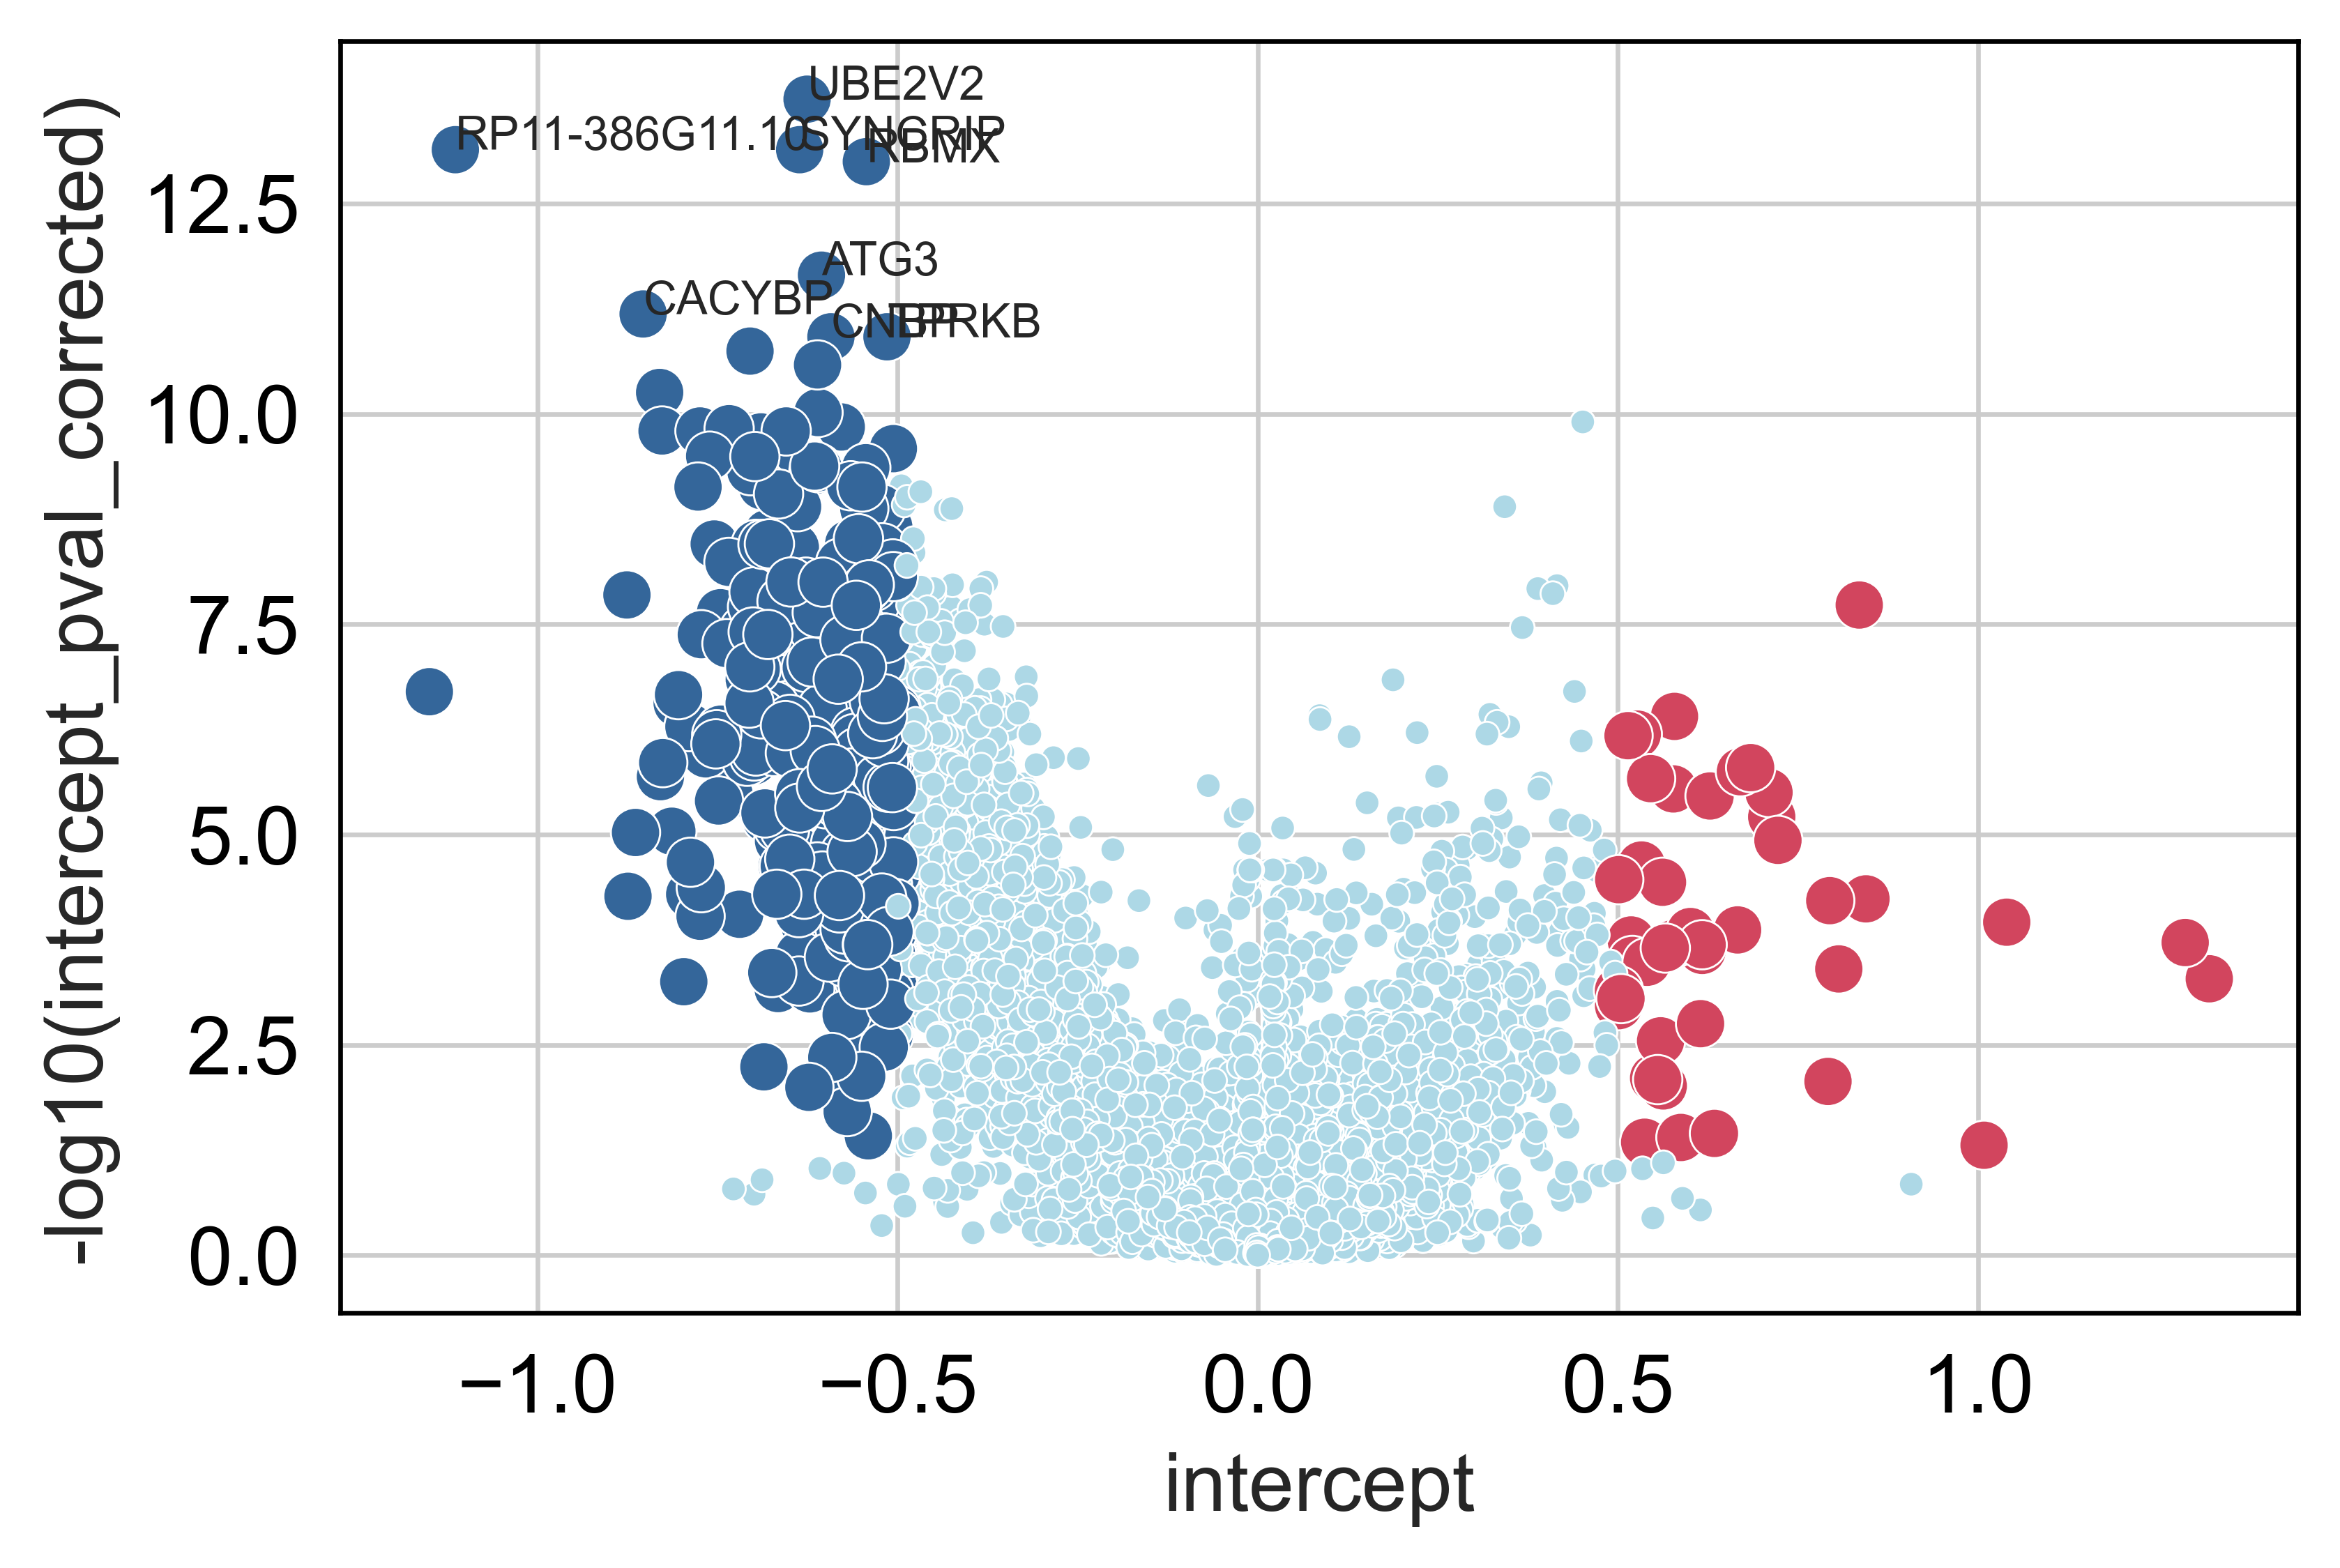

In [19]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.05, value_threshold=0.5)

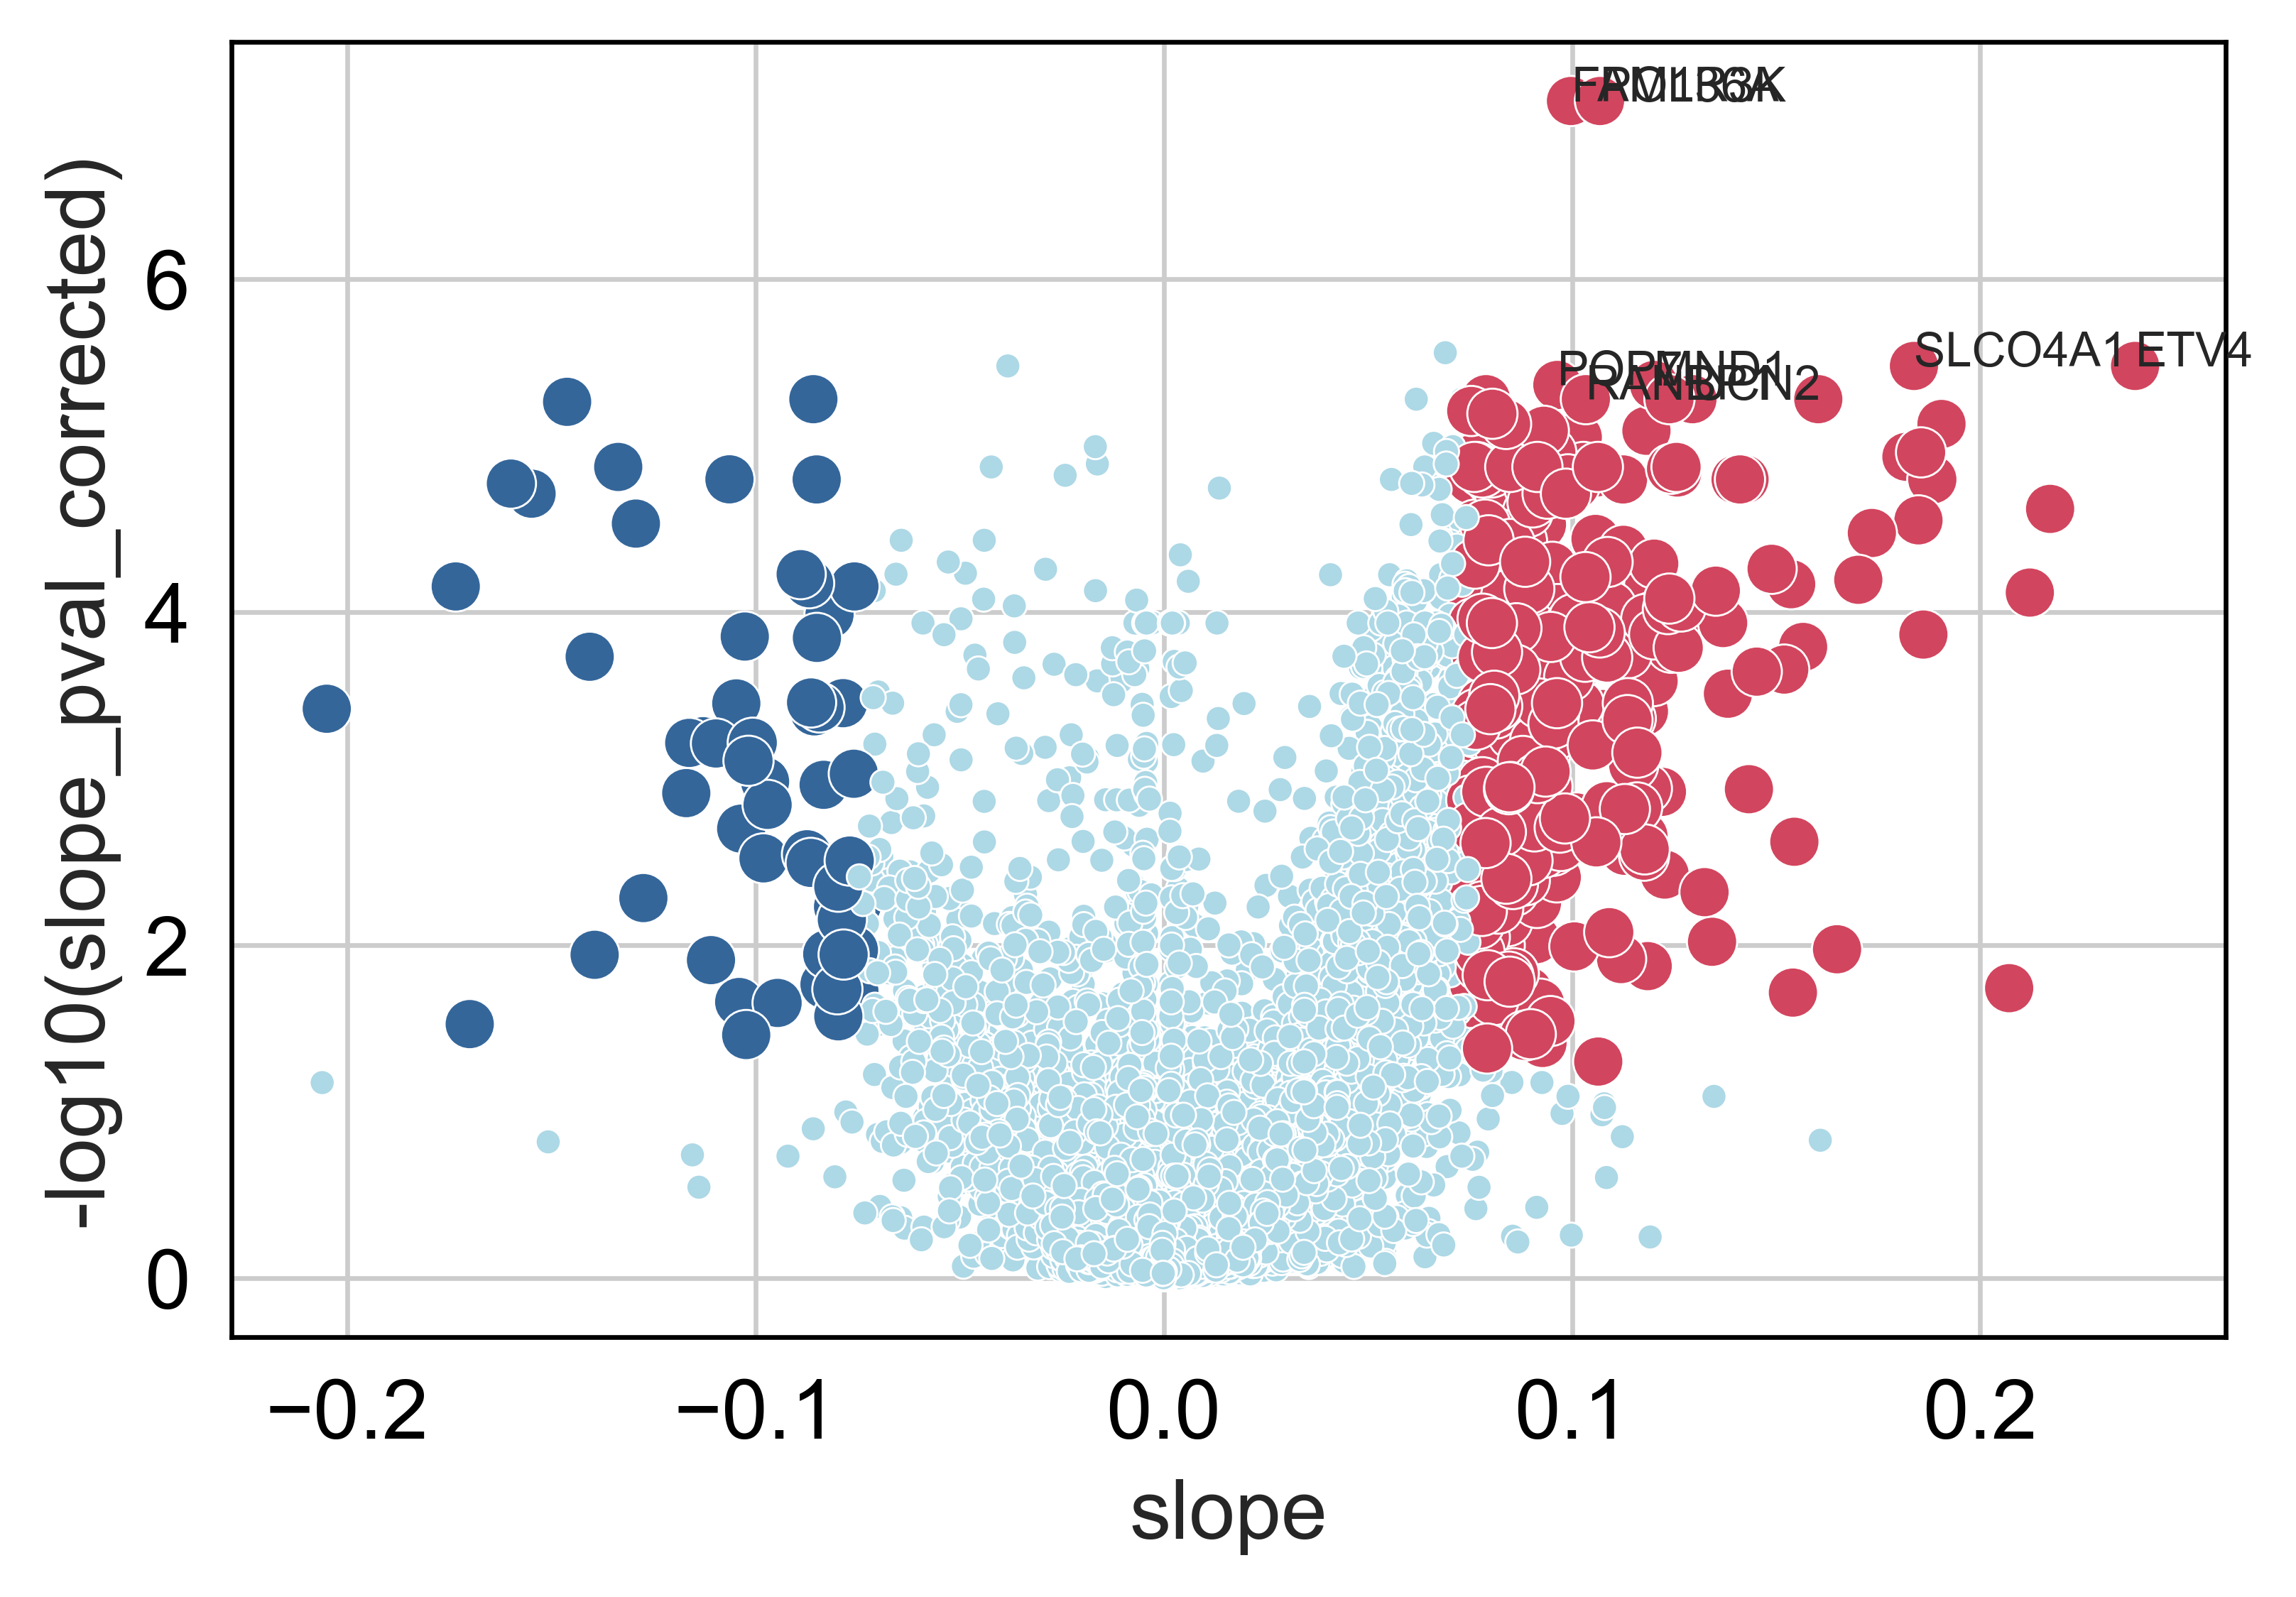

In [20]:
volcano_plot(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.05, value_threshold=0.075)

In [21]:
plot_example_linear_regression(adata, "Dabrafenib", "UBE2V2", 2, logfc_df_dabrafenib)

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


In [22]:
plot_example_linear_regression(adata, "Dabrafenib", "ETV4", 2, logfc_df_dabrafenib)

perturbation
control       29143
Dabrafenib    12814
Name: count, dtype: int64


Number of genes UP: 878, DOWN: 3659
['BP' 'CC' 'MF' 'cor' 'hp' 'keg' 'mir' 'rea']
Number of pathways UP: 208, DOWN: 3156


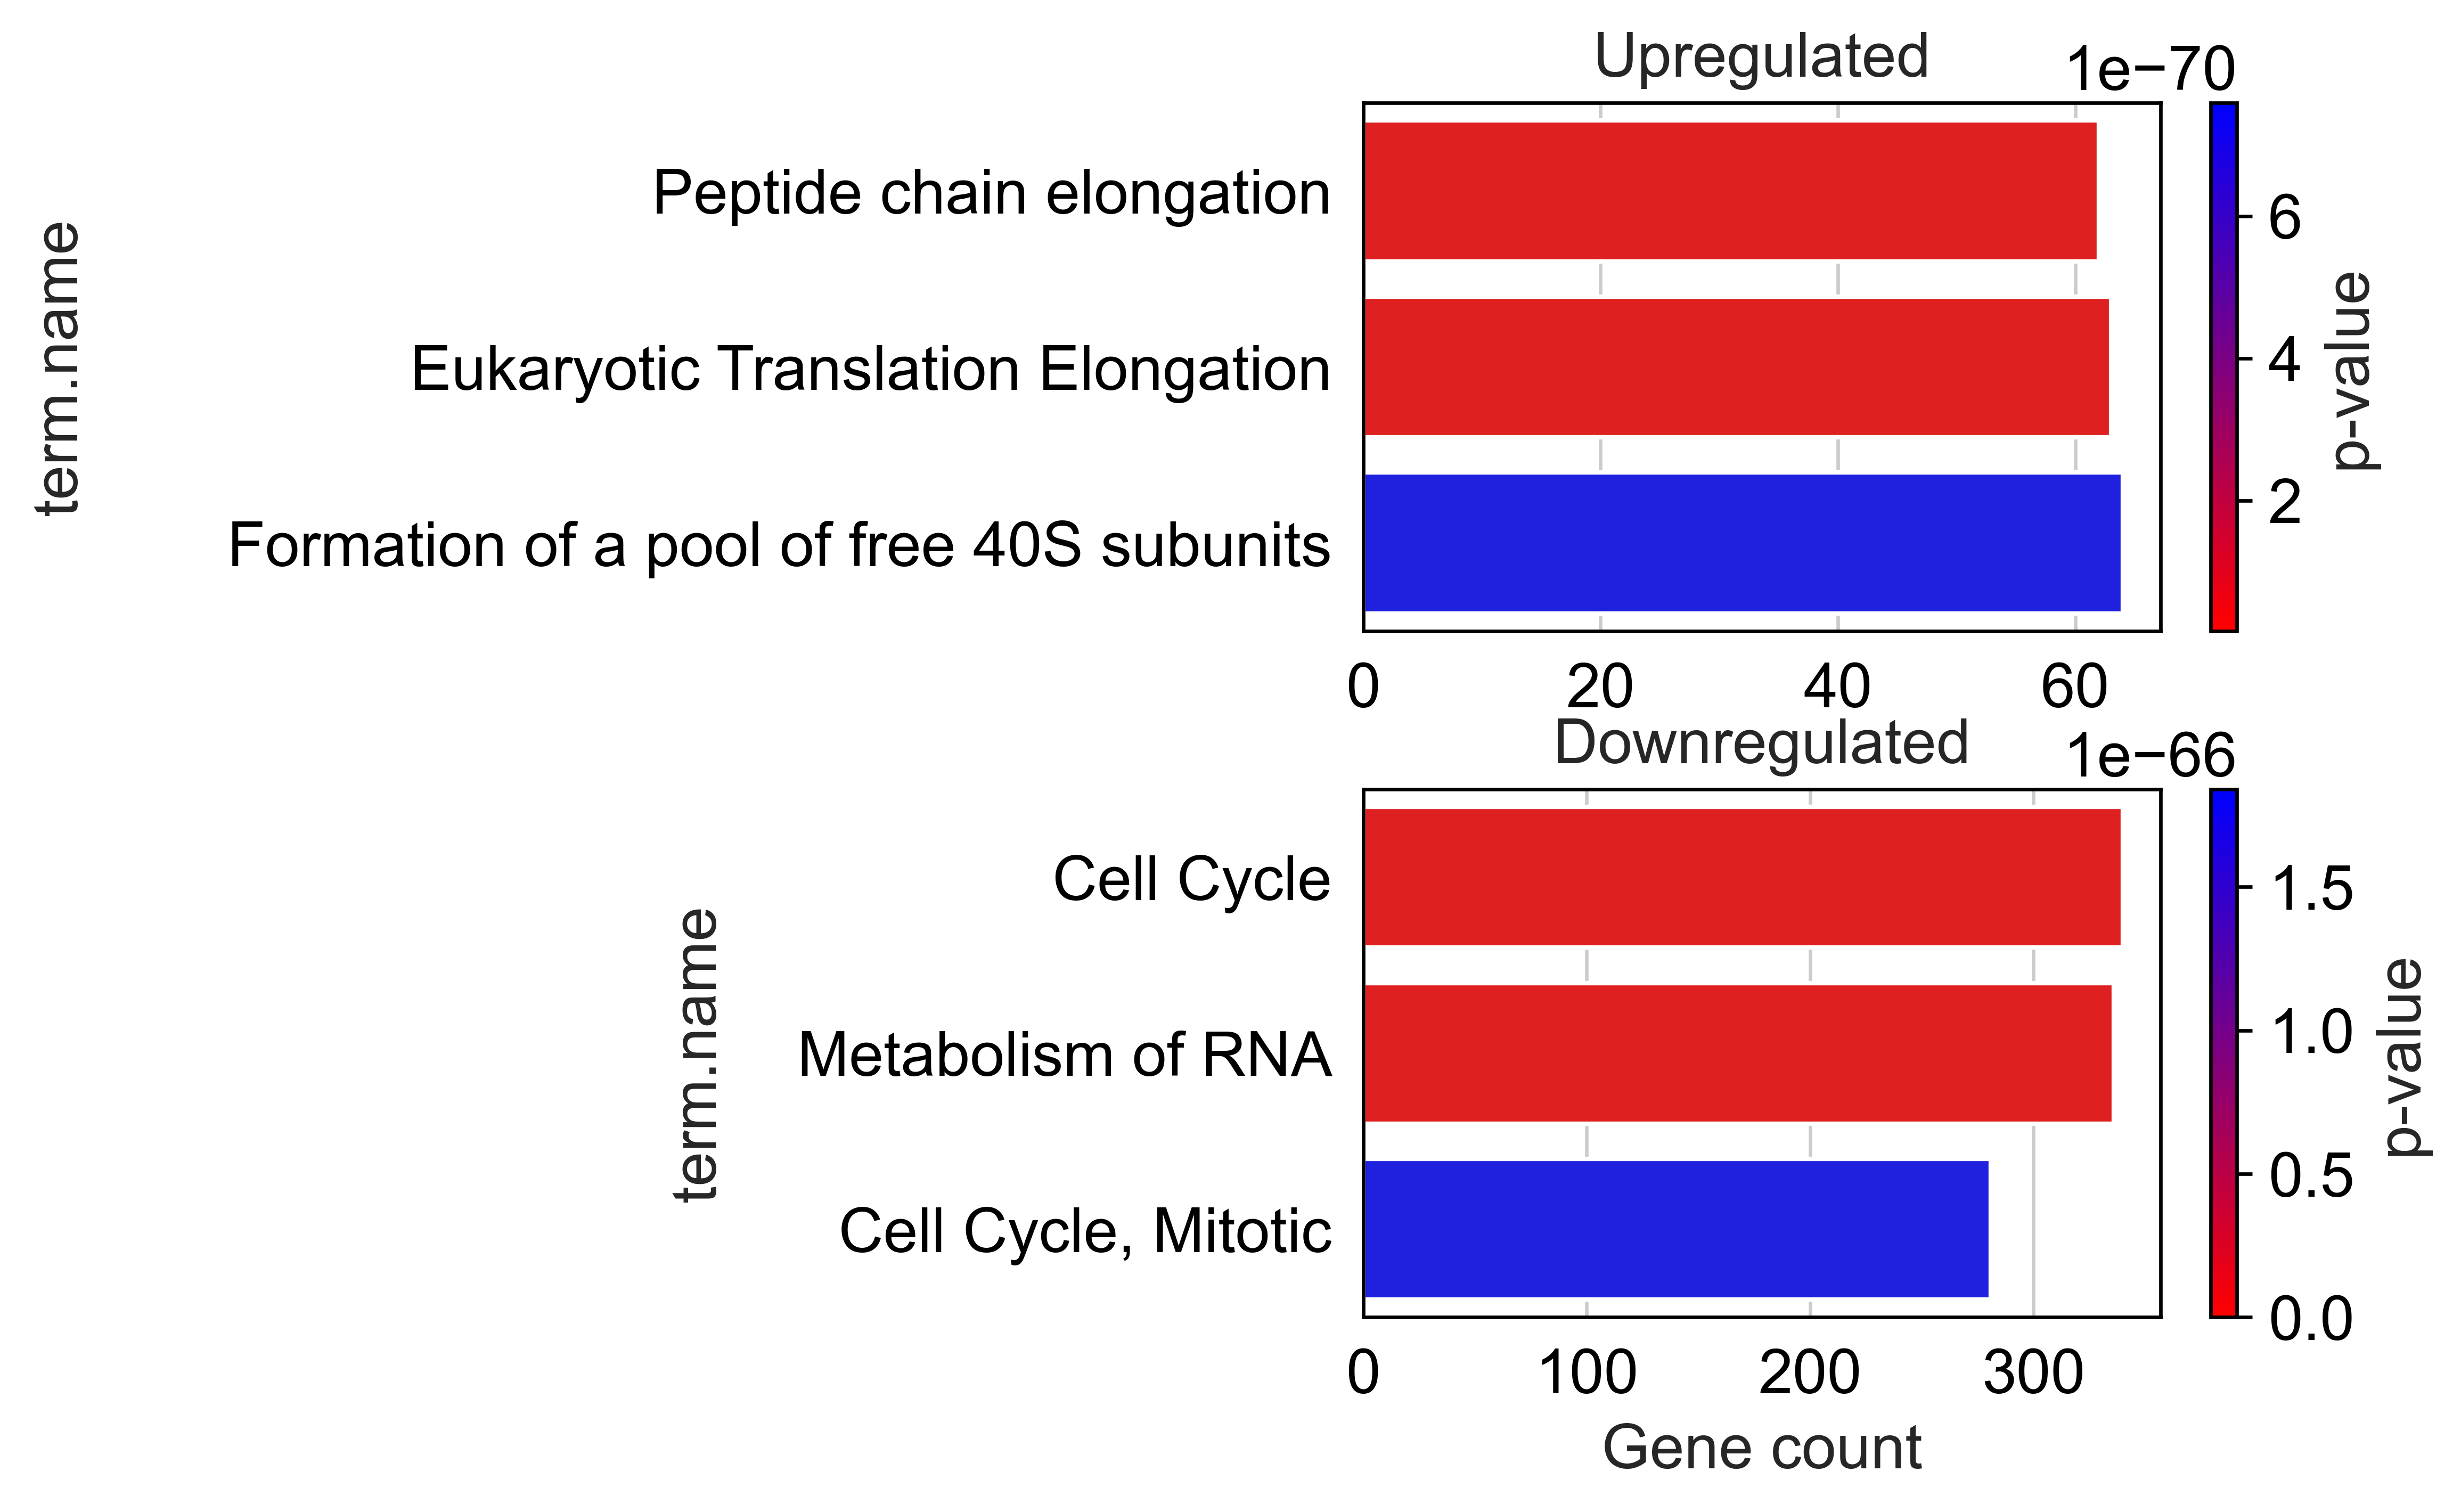

In [23]:
gsea(lr_params_dabrafenib, "Dabrafenib", "intercept", pval_threshold=0.05, domain="rea")

Number of genes UP: 2058, DOWN: 494
['BP' 'CC' 'MF' 'cor' 'hp' 'hpa' 'keg' 'mir' 'rea' 'tf']
Number of pathways UP: 2394, DOWN: 34


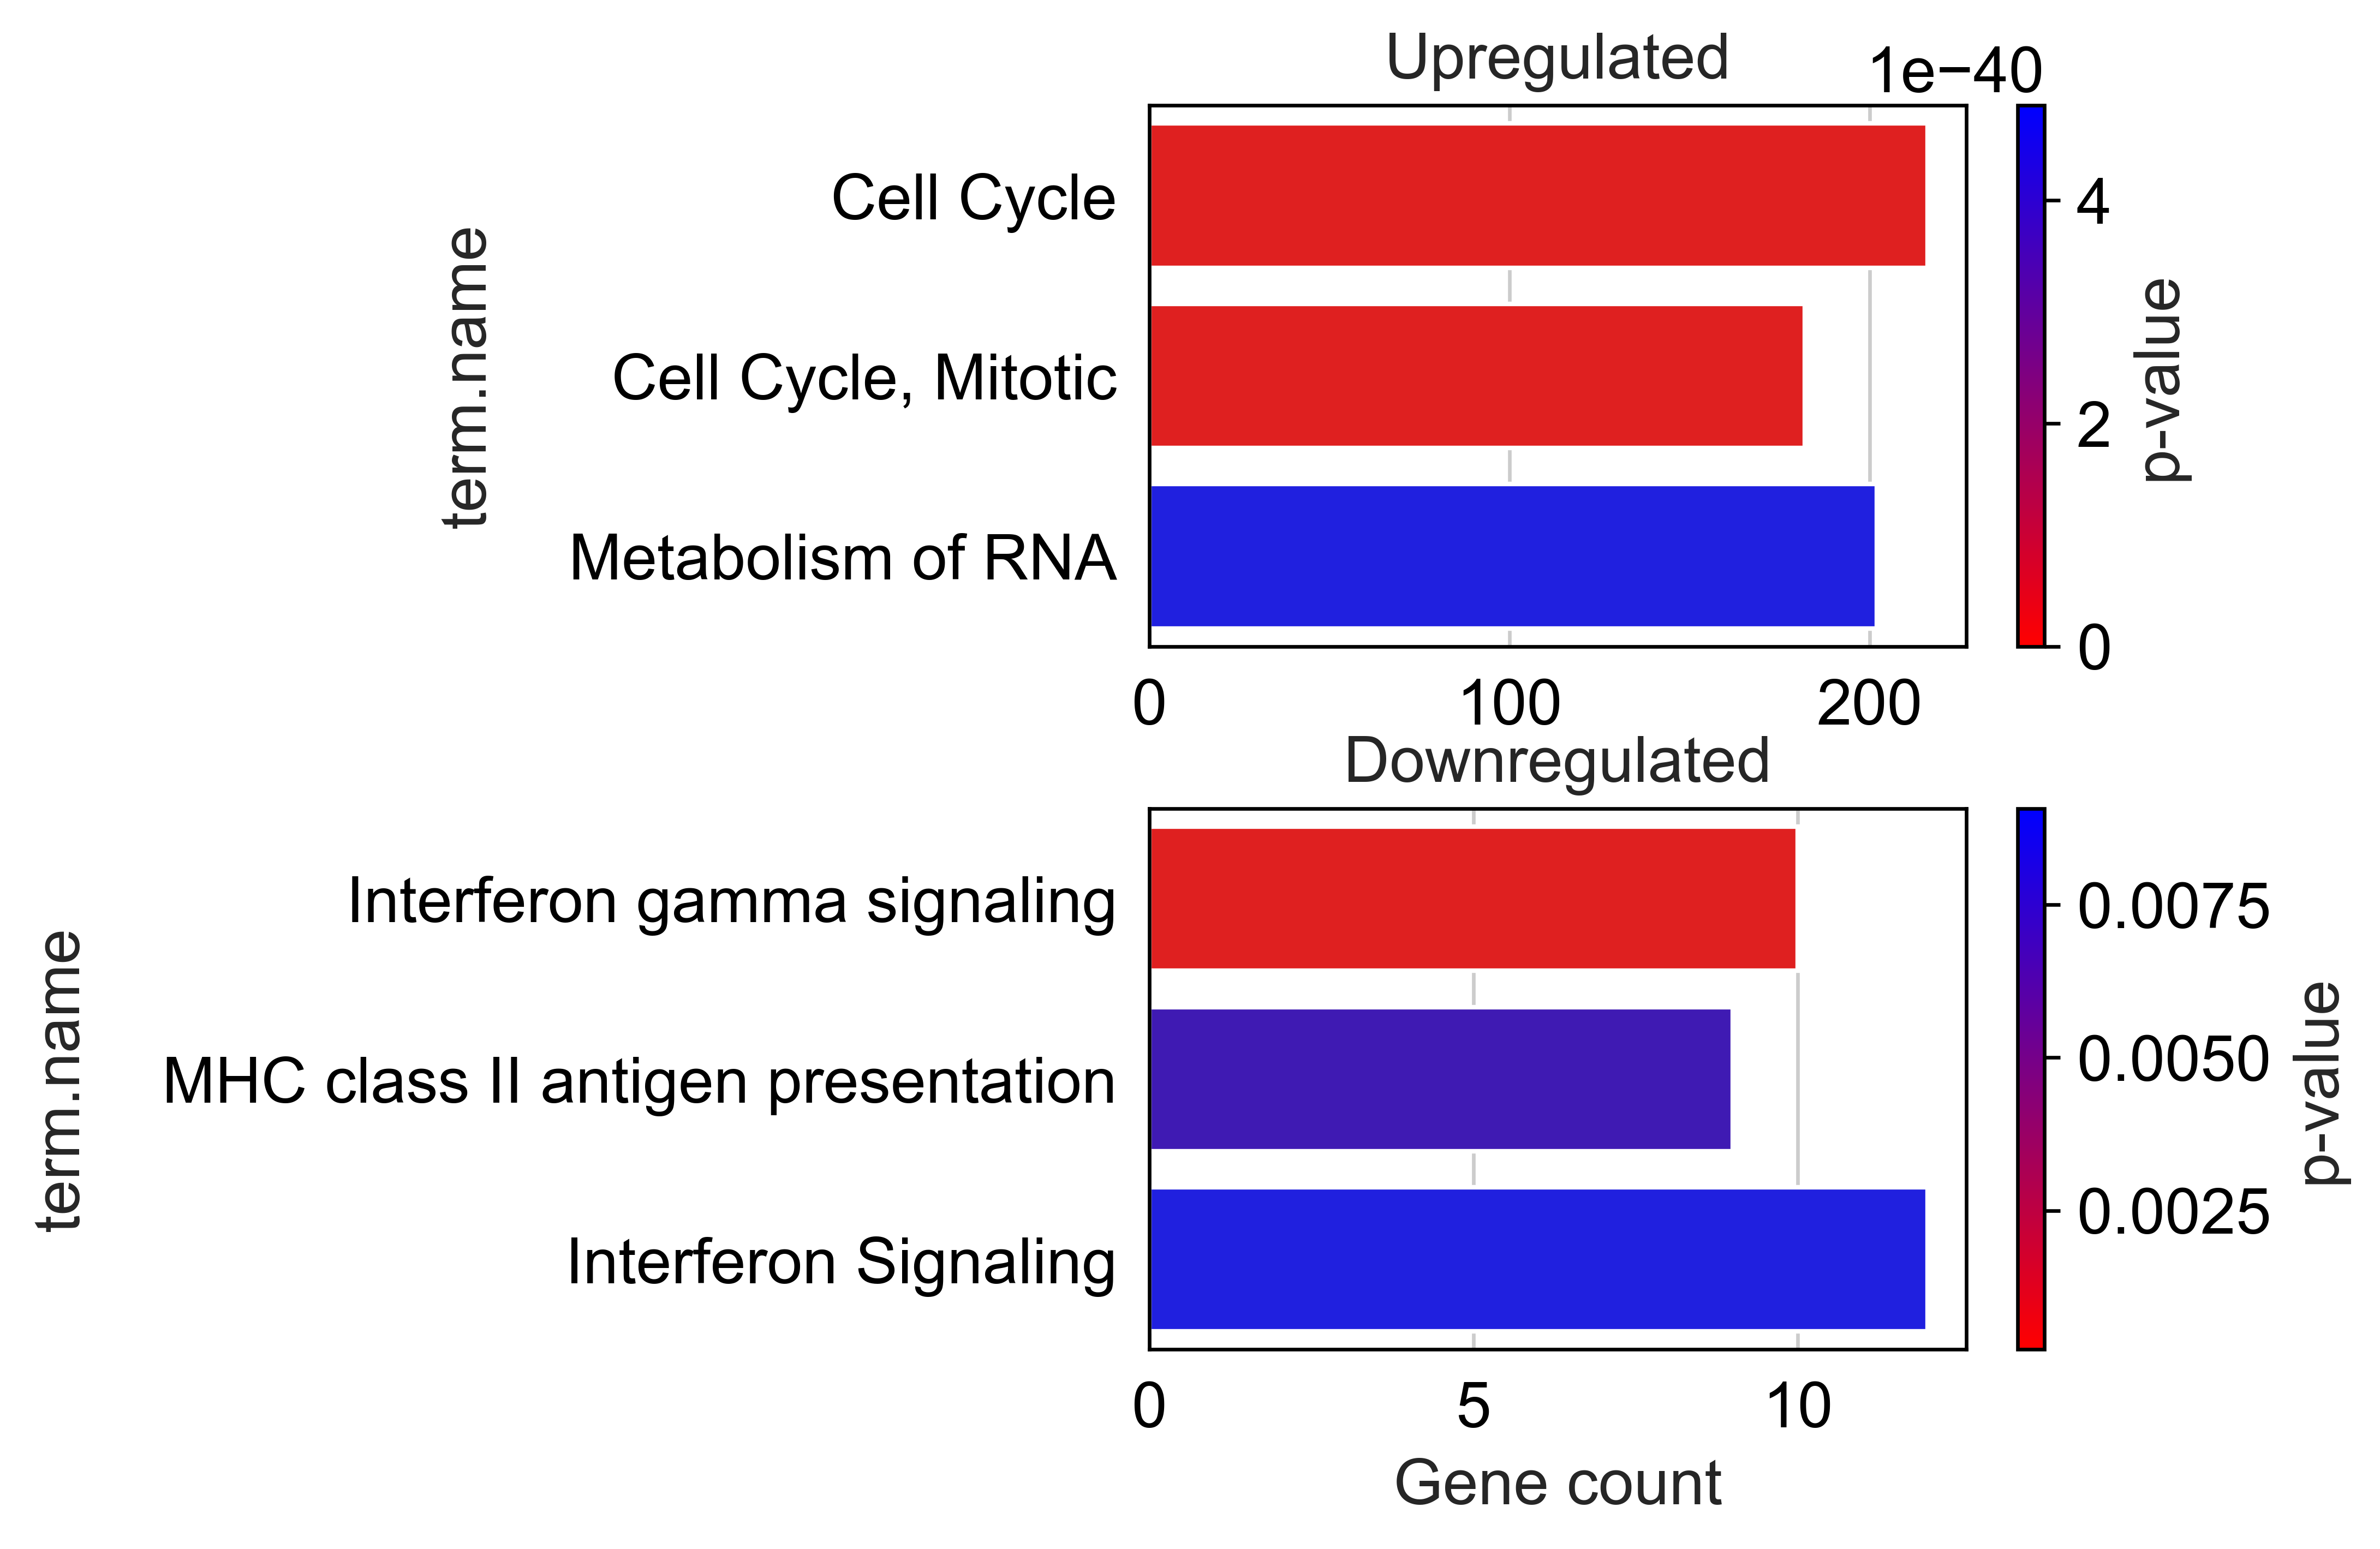

In [24]:
gsea(lr_params_dabrafenib, "Dabrafenib", "slope", pval_threshold=0.05, domain="rea")

In [25]:
lr_params_dabrafenib[(lr_params_dabrafenib["slope"] > 0.08) & (lr_params_dabrafenib["-log10(slope_pval_corrected)"] > 6)]

,gene,slope,intercept,slope_pval,intercept_pval,slope_pval_corrected,intercept_pval_corrected,-log10(slope_pval_corrected),-log10(intercept_pval_corrected),color,size
FAM136A,FAM136A,0.099750,-0.453821,6.060119e-12,1.330250e-10,8.501135e-08,3.217371e-08,7.070523,7.492499,red,1.1
POLR3K,POLR3K,0.106854,-0.564965,5.507538e-12,7.918018e-13,8.501135e-08,7.166062e-10,7.070523,9.144719,red,1.1
